In [1]:
import ioh
import numpy as np
import iohinspector
import matplotlib.pyplot as plt
from modcma import c_maes

In [2]:
FUNCTIONS = list(range(1, 25))
INSTANCES = list(range(1, 15))
DIMENSIONS = (2, 3, 5, 10)
N_REP = 5
BUDGET_FACTOR = 30
DOE_FACTOR = 3

In [9]:
def random_search(problem: ioh.ProblemType, budget: int):
    for _ in range(budget):
        x = np.random.uniform(problem.bounds.lb, problem.bounds.ub)
        y = problem(x)
    return problem.state.current_best


def cmaes(problem: ioh.ProblemType, budget: int):
    settings = c_maes.settings_from_dict(
        problem.meta_data.n_variables,
        budget=budget,
        lb=problem.bounds.lb,
        ub=problem.bounds.ub,
        target=problem.optimum.y + 1e-8,
        active=True
    )
    es = c_maes.ModularCMAES(settings)
    es.run(problem)
    
def one_plus_one_cmaes(problem: ioh.ProblemType, budget: int):
    settings = c_maes.settings_from_dict(
        problem.meta_data.n_variables,
        budget=budget,
        lb=problem.bounds.lb,
        ub=problem.bounds.ub,
        target=problem.optimum.y + 1e-8,
        lambda0=1,
        mu0=1
    )
    es = c_maes.ModularCMAES(settings)
    es.run(problem)                 

In [10]:
def run_benchmark(name, alg, logged = True):
    if logged:
        logger = ioh.logger.Analyzer(
            algorithm_name=name,
            folder_name=name,
            root = 'data'
        )
    
    c_maes.utils.set_seed(12)
    np.random.seed(12)
    
    for dim in DIMENSIONS:
        for fid in FUNCTIONS:
            for iid in INSTANCES:
                problem = ioh.get_problem(fid, iid, dim)
                budget = BUDGET_FACTOR * dim
                
                if logged:
                    problem.attach_logger(logger)
                for rep in range(N_REP):
                    alg(problem, budget)
                    problem.reset()
                    
                    
run_benchmark("RandomSearch", random_search, True)
run_benchmark("CMA-ES", cmaes, True)
run_benchmark("(1+1)-CMA-ES", one_plus_one_cmaes, True)             

In [12]:
manager = iohinspector.manager.DataManager()
manager.add_folder("data")

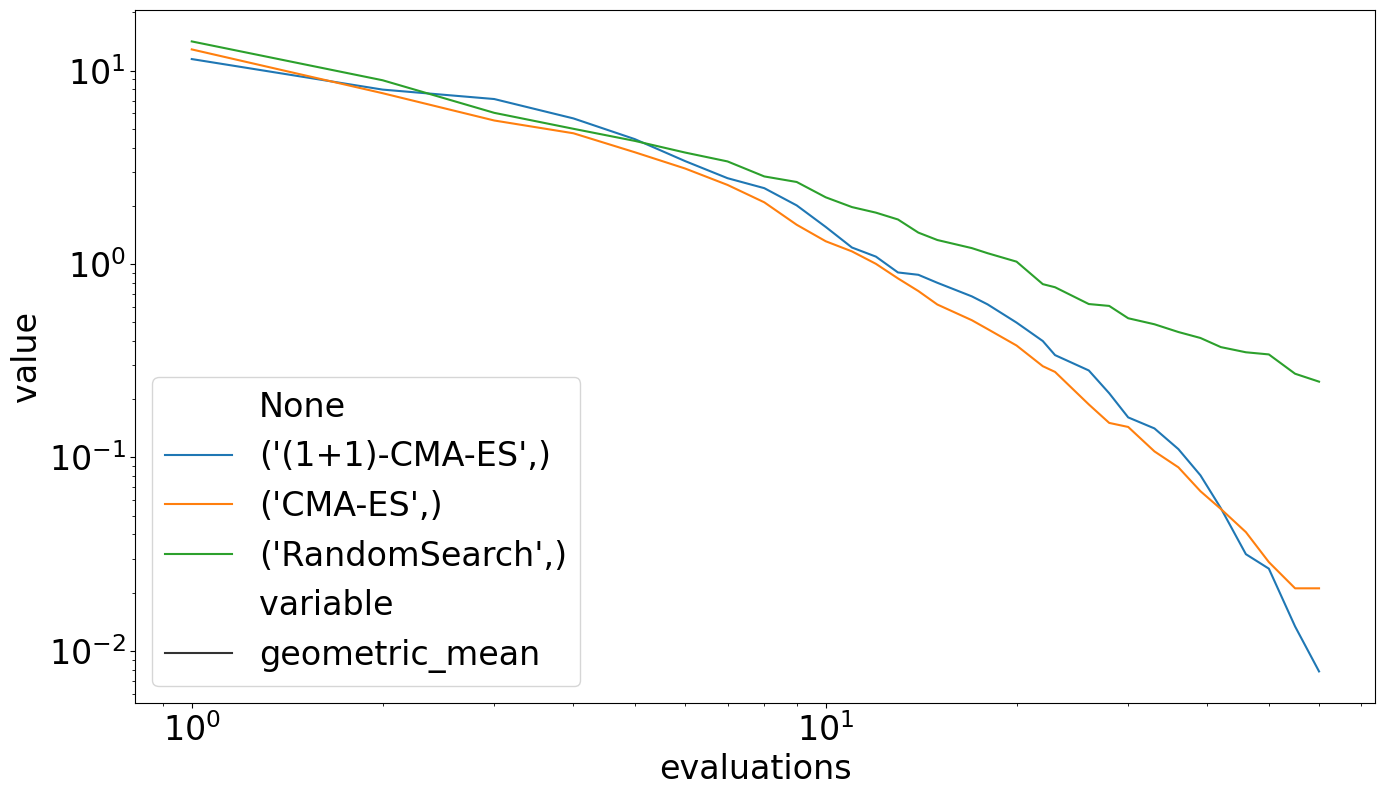

In [ ]:
selection = manager.select(function_ids=[1], dimensions=[2])
df = selection.load(monotonic=True, include_meta_data=True)
iohinspector.plot.single_function_fixedbudget(df);